<a href="https://colab.research.google.com/github/neel-madhav/HealthcarePremiumPrediction/blob/main/PremiumPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV



# Import data and Formatting

In [ ]:
df = pd.read_excel("premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [ ]:
df.shape

(50000, 13)

In [ ]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [ ]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

# Data Preprocessing and Exploratory Data Analysis (EDA)

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,11
employment_status,2
income_level,13
income_lakhs,0


###Handle NA values


In [ ]:
df = df.dropna()
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,0
employment_status,0
income_level,0
income_lakhs,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [ ]:
df[df.number_of_dependants < 0].shape

(72, 13)

In [ ]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1])

In [ ]:
df['number_of_dependants'] = df['number_of_dependants'].abs()
df.describe()

/tmp/ipython-input-225-796334279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_dependants'] = df['number_of_dependants'].abs()


,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


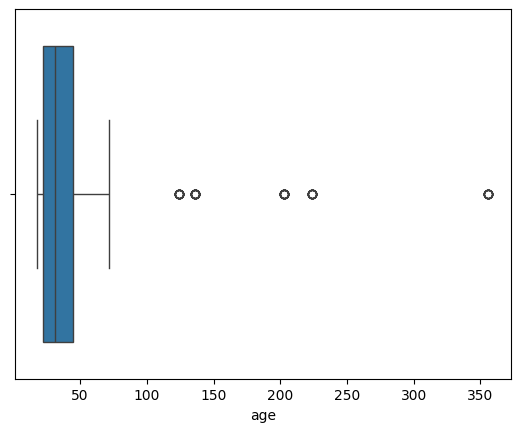

In [ ]:
sns.boxplot(x = df['age'])
plt.show()

In [ ]:
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

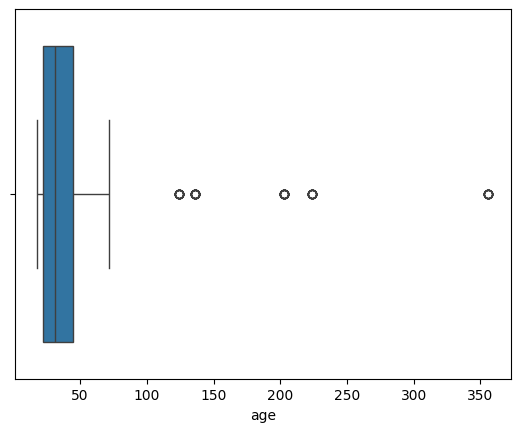

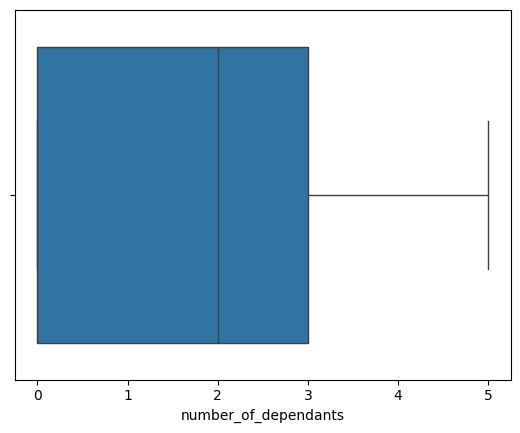

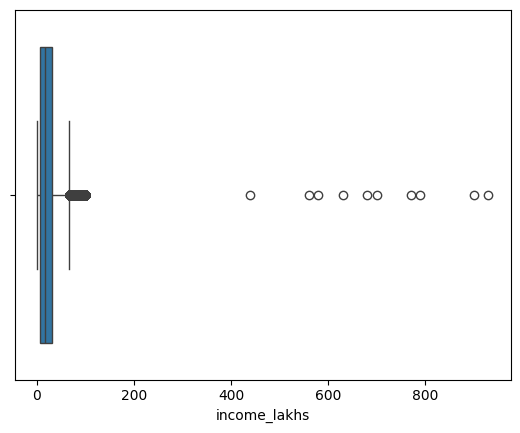

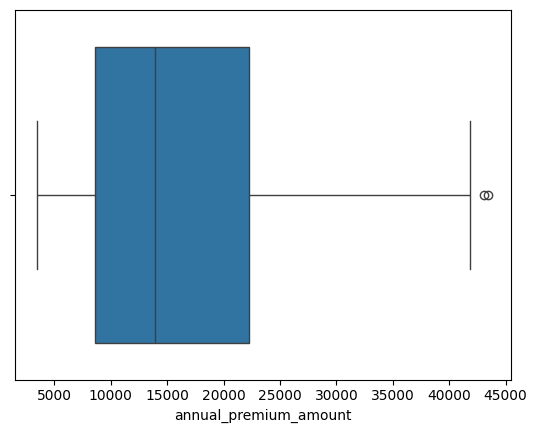

In [ ]:
for col in numeric_columns:
  sns.boxplot(x = df[col])
  plt.show()



In [ ]:
df = df[df.age < 100].copy()

In [ ]:
df.income_lakhs.quantile([0.25, 0.75])

,income_lakhs
0.25,7.0
0.75,31.0


In [ ]:
def get_iqr_bounds(col):
  Q1, Q3 = col.quantile([0.25, 0.75])
  IQR = Q3-Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR
  return lower_bound, upper_bound

In [ ]:
get_iqr_bounds(df.income_lakhs)

(-29.0, 67.0)

In [ ]:
df.income_lakhs.quantile(.999)

np.float64(100.0)

In [ ]:
df = df[df.income_lakhs < 100]
df = df[df.age < 100]

In [ ]:
df.shape

(49808, 13)

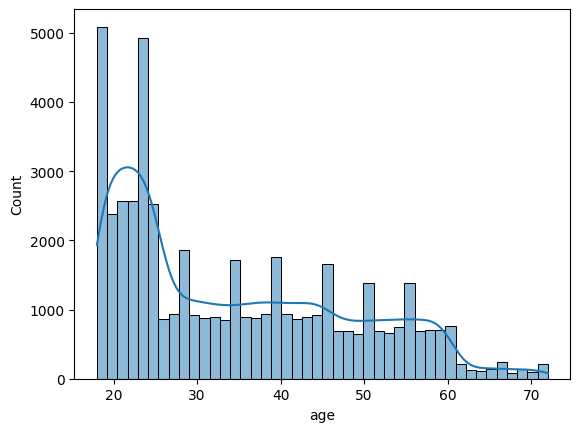

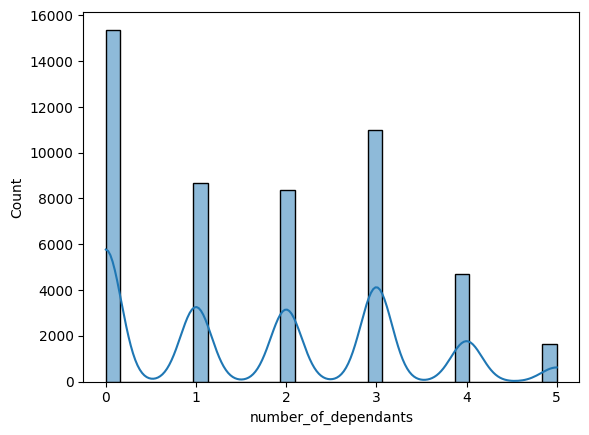

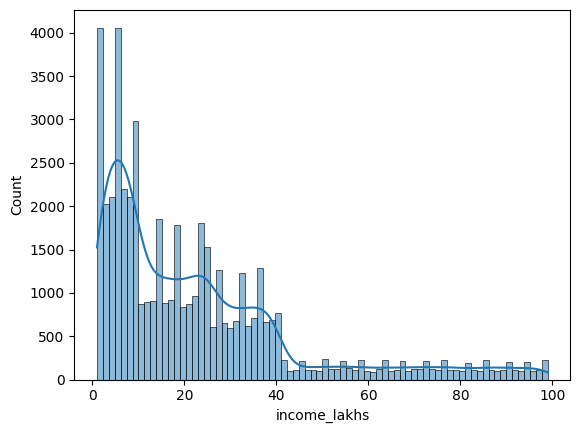

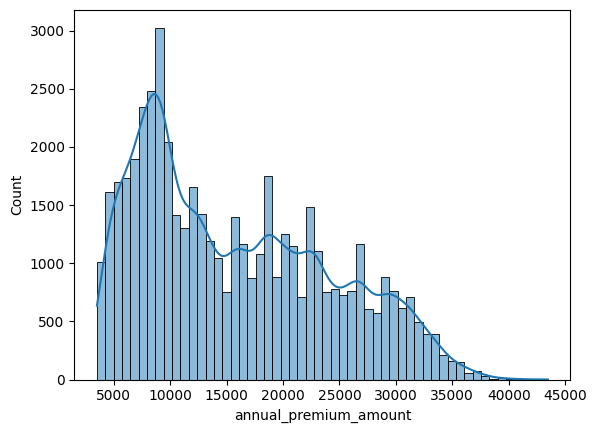

In [ ]:
for col in numeric_columns:
  sns.histplot(x = df[col], kde = True)
  plt.show()



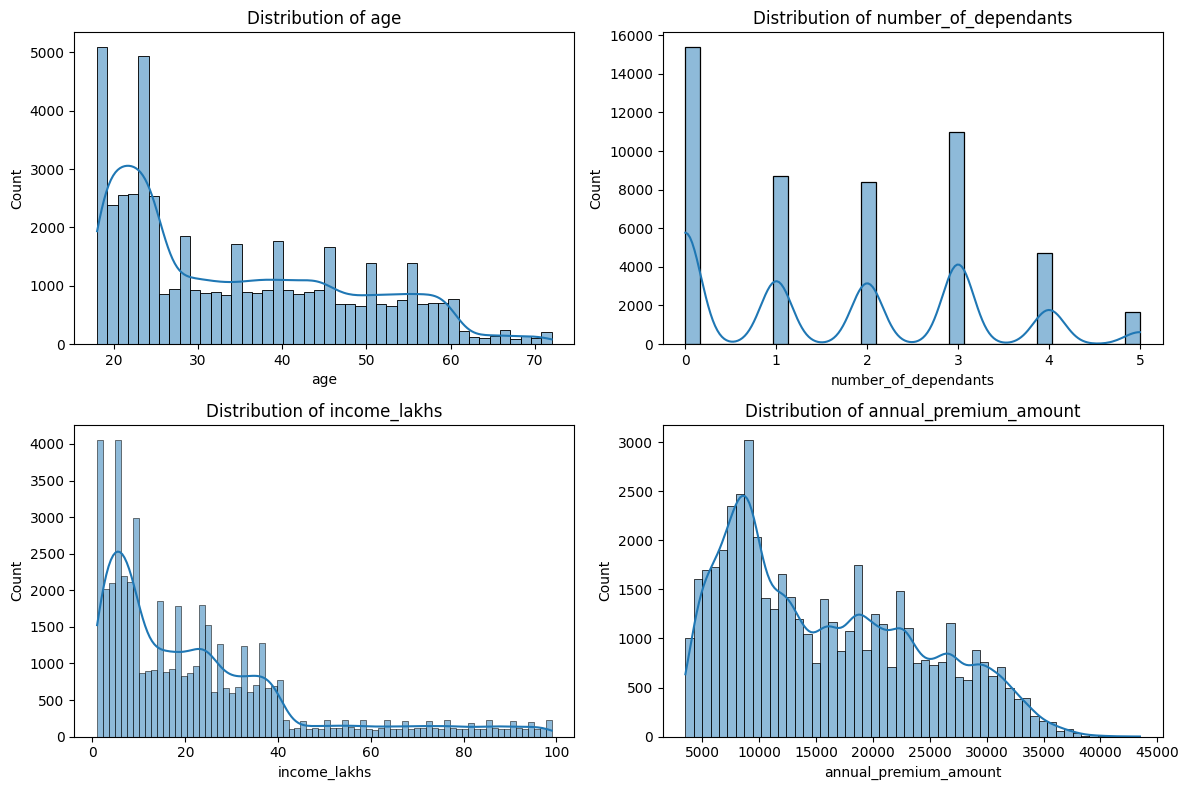

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))  # 2 rows × 2 columns
axes = axes.flatten()  # Flatten the 2D array of axes to loop easily

for i, col in enumerate(numeric_columns[:4]):  # Ensure only 4 columns are plotted
    sns.histplot(x=df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

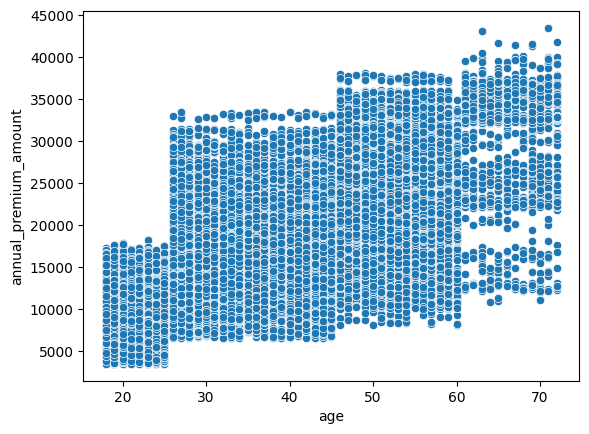

In [ ]:
sns.scatterplot(df, x = 'age', y = 'annual_premium_amount')
plt.show()

In [ ]:
categorical_columns = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history']
for col in categorical_columns:
  print(col, ":", df[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']


In [ ]:
df['smoking_status'] = df['smoking_status'].replace(
    {'Smoking=0': 'No Smoking', 'Does Not Smoke': 'No Smoking', 'Not Smoking': "No Smoking"}
)
df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [ ]:
percentage_count = df['gender'].value_counts(normalize = True)
percentage_count

,proportion
gender,
Male,0.54953
Female,0.45047


In [ ]:
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,5307,3880,5182
25L - 40L,3683,2840,3750
<10L,12226,931,5486
> 40L,326,3593,2604


insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              326  3593    2604


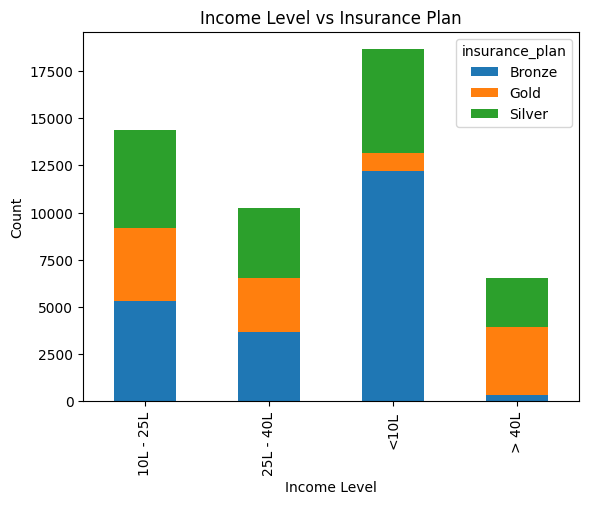

In [ ]:
print(crosstab)
crosstab.plot(kind = "bar", stacked = True)
plt.title("Income Level vs Insurance Plan")
plt.xlabel("Income Level")
plt.ylabel("Count")
plt.show()

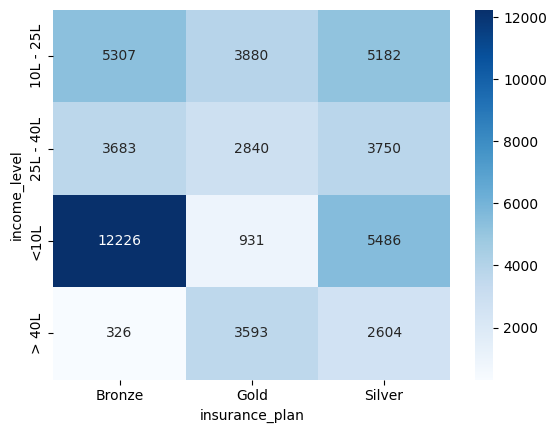

In [ ]:
sns.heatmap(crosstab, annot = True, cmap = "Blues", fmt = 'd')
plt.show()

#Feature Engineering


In [ ]:
df['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [ ]:
risk_score = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0

}
df[["Disease1", "Disease2"]] = df['medical_history'].str.split(" & ", expand = True).apply(lambda x: x.str.lower())

In [ ]:
df['Disease1'] = df['Disease1'].fillna('none')
df['Disease2'] = df['Disease2'].fillna('none')
df['total_risk_score'] = 0

for disease in ['Disease1', 'Disease2']:
  df['total_risk_score'] += df[disease].map(risk_score)

In [ ]:
max_score = df['total_risk_score'].max()
min_score = df['total_risk_score'].min()
df['normalised_risk_score'] = (df['total_risk_score'] - min_score) / (max_score - min_score)
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,Disease1,Disease2,total_risk_score,normalised_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571


In [ ]:
df['insurance_plan'].unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [ ]:
df['insurance_plan'] = df['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df.insurance_plan.unique()

array([1, 2, 3])

In [ ]:
df['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [ ]:
df['income_level'] = df['income_level'].map({'<10L':1, '10L - 25L':2, '25L - 40L': 3,'> 40L':4})
df.income_level.unique()

array([1, 2, 4, 3])

In [ ]:
nominal_columns = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df = pd.get_dummies(df, columns = nominal_columns, drop_first = True, dtype = int)

In [ ]:
df.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,Disease1,Disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [ ]:
df = df.drop(["medical_history", "Disease1", "Disease2", "total_risk_score"], axis = 1)

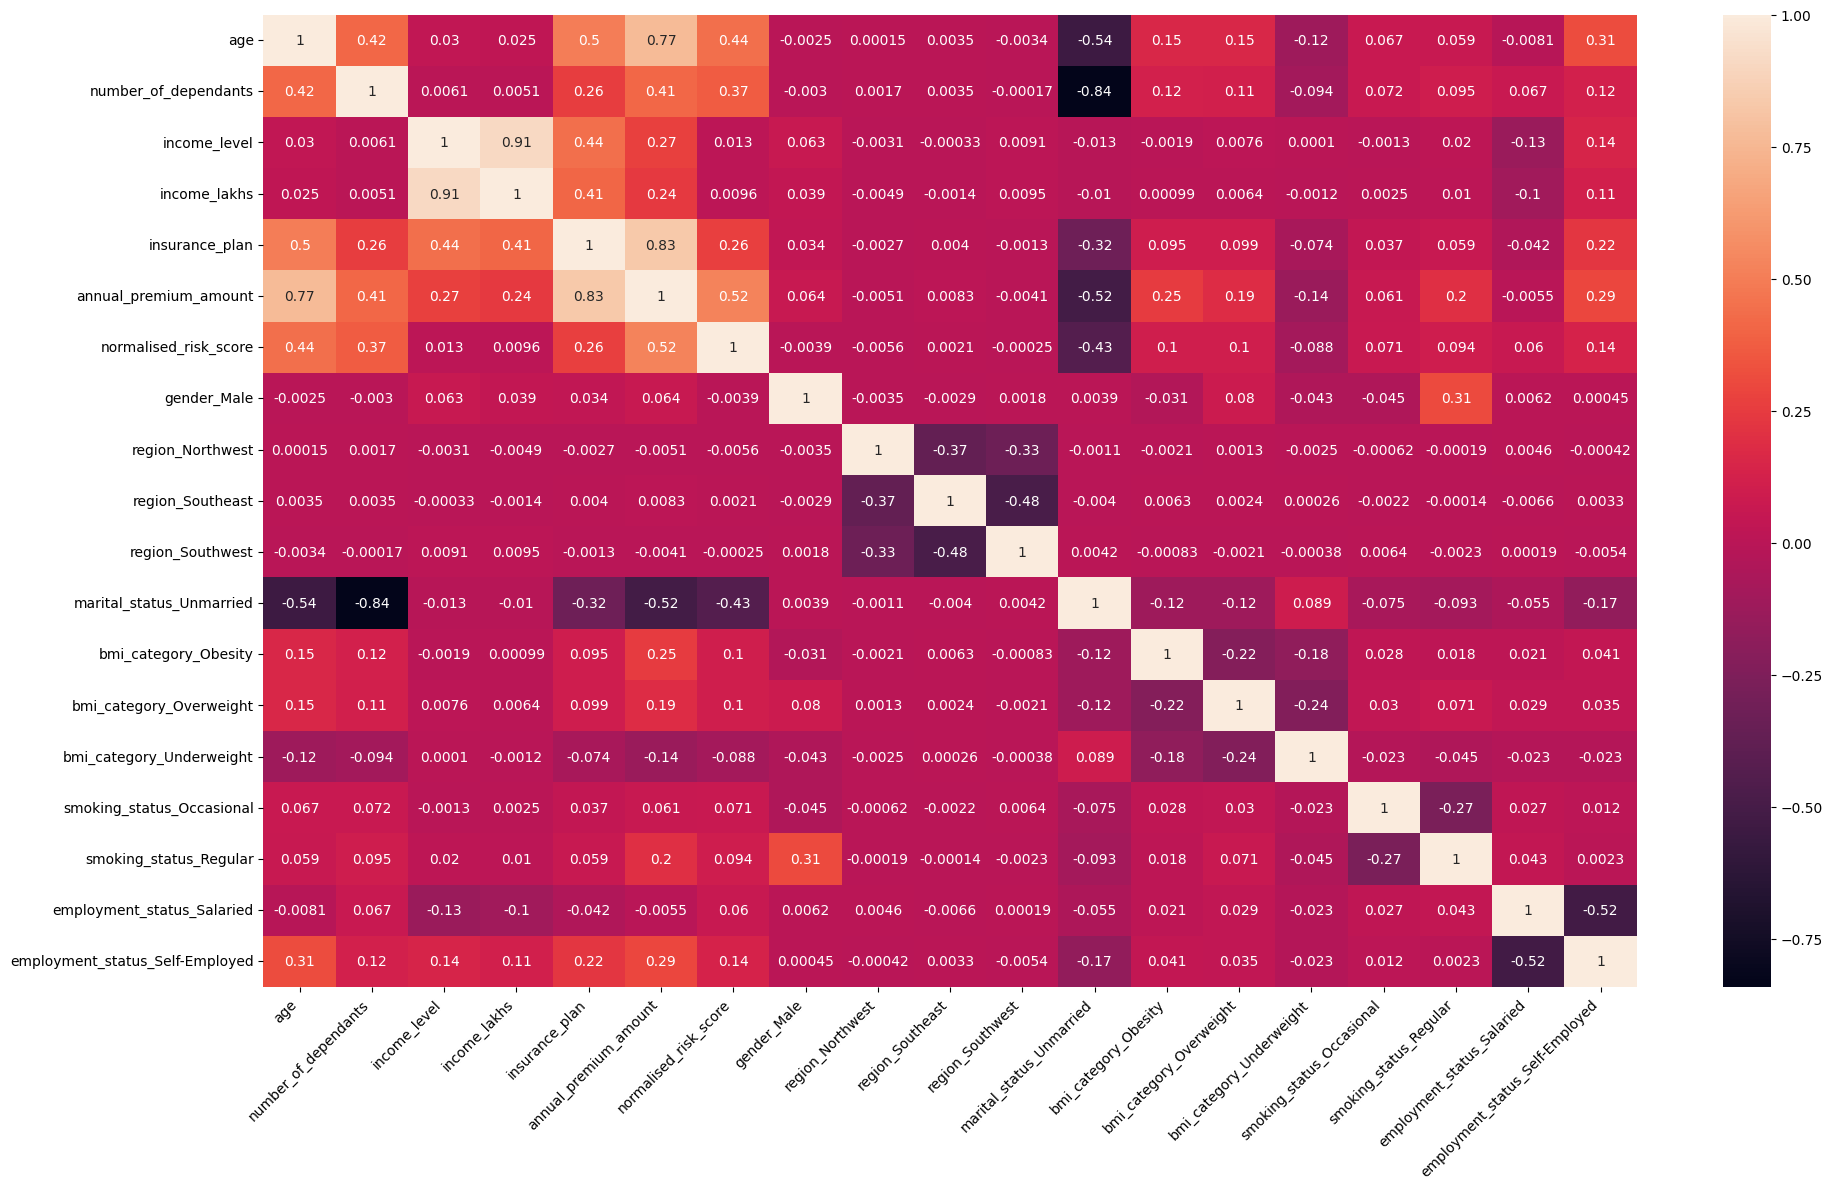

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize = (20,12))
sns.heatmap(correlation_matrix, annot = True)
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()


###Find Variance Inflation Factor

In [ ]:
X = df.drop('annual_premium_amount', axis = 'columns')
y = df['annual_premium_amount']

In [ ]:
df.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler
columns_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

In [ ]:
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.051020,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.051020,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.193878,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.775510,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,1.000000,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [ ]:
X = X.drop('income_level', axis = 'columns')

In [ ]:
X.describe()

,age,number_of_dependants,income_lakhs,insurance_plan,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000
mean,0.303691,0.343443,0.221787,0.396623,0.291816,0.549530,0.200972,0.350365,0.302963,0.513693,0.143250,0.231148,0.155276,0.138291,0.313765,0.419471,0.272004
std,0.253393,0.298411,0.223692,0.392273,0.287456,0.497546,0.400731,0.477089,0.459544,0.499817,0.350331,0.421571,0.362171,0.345209,0.464027,0.493477,0.444997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.061224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.153061,0.500000,0.357143,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.306122,0.500000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#Model Training


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)
print("XTRAIN", X_train.shape)
print("XTEST", X_test.shape)
print("YTRAIN", Y_train.shape)
print("YTEST", Y_test.shape)

XTRAIN (34865, 17)
XTEST (14943, 17)
YTRAIN (34865,)
YTEST (14943,)


In [ ]:
Model_LinearRegression = LinearRegression()
Model_LinearRegression.fit(X_train, Y_train)
Model_LinearRegression.score(X_test, Y_test)

0.9277068802881225

In [266]:
Model_LinearRegression.intercept_

np.float64(4721.284227923574)

In [267]:
Model_LinearRegression.coef_

array([11320.84480976,  -598.60654635,  -387.23104353, 12445.21223389,
        4830.35511008,   141.16467047,   -19.93312597,    72.90102336,
          18.96701435,  -880.43219853,  3363.77237148,  1616.18488467,
         359.97028802,   679.17891348,  2239.27098107,   165.26365654,
         414.73816833])